In [79]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)


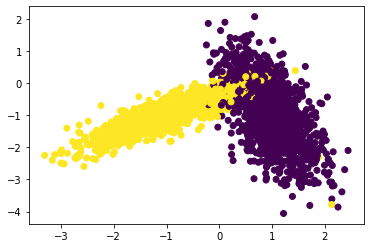

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [81]:
def RandomSearchCV(x_tr,y_tr,classifier,param_range,folds):
    """This function implements hypermeter tuning using Rnadomized Search."""
    
    no_samples=30
    params=sorted(random.sample(range(param_range[0],param_range[1]+1),no_samples))
    groups=[x for x in range(0,len(x_tr),len(x_tr)//folds)]
    print(groups)
    
    trainscores = []
    cvscores = []
    
    for k in tqdm(params):
        trainscores_folds = []
        cvscores_folds = []
        
        for i in range(folds):
            if(i!=folds-1):
                cv_indices=list(range(groups[i],groups[i+1]))
            else:
                cv_indices=list(range(groups[i],len(x_tr)))
            
            tr_indices=list(set(range(len(x_tr)))-set(cv_indices))
           
            X_train = x_tr[tr_indices]
            Y_train = y_tr[tr_indices]
            X_cv  = x_tr[cv_indices]
            Y_cv  = y_tr[cv_indices]

            classifier.n_neighbors = k
            classifier.fit(X_train,Y_train)
            
            Y_pred = classifier.predict(X_cv)
            cvscores_folds.append(accuracy_score(Y_cv, Y_pred))
            
            Y_pred = classifier.predict(X_train)
            trainscores_folds.append(accuracy_score(Y_train,Y_pred))
            
        trainscores.append(np.mean(np.array(trainscores_folds)))
        cvscores.append(np.mean(np.array(cvscores_folds)))
        
    return params,trainscores,cvscores

[0, 750, 1500, 2250, 3000, 3750, 4500, 5250, 6000, 6750]


100%|██████████| 30/30 [02:57<00:00,  5.93s/it]


[12, 22, 24, 25, 30, 35, 37, 41, 45, 53, 65, 66, 68, 74, 85, 104, 111, 129, 131, 133, 151, 152, 153, 157, 159, 169, 178, 180, 182, 190]


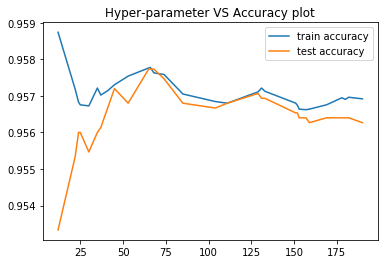

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random

param_range=(1,200) # Having a large range would give accurate results.
folds=10           # 10-fold cross validation.

classifier=KNeighborsClassifier()

params,trainscores,testscores=RandomSearchCV(X_train,y_train,classifier,param_range,folds)
print((params))

plt.plot(params,trainscores, label='train accuracy')
plt.plot(params,testscores, label='test accuracy')
plt.title('Hyper-parameter VS Accuracy plot')
plt.legend()
plt.show()

#### As observed from the plots
1. Cross Validation accuracy is high at k = 70 and k=129
2. At these values Training accuracy is also high
3. From these two values, we can observe Training accuracy and Cross validation
accuracy are higher for k=70 than k=129
4. So we choose K=70 as the optimal_K.

In [85]:
def plot_decision_boundary(X1, X2, y, clf):
       
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
  
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

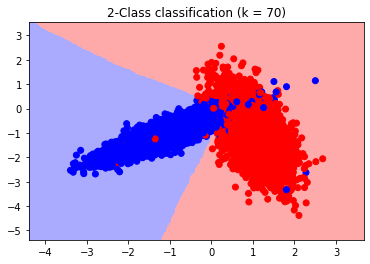

Test_accuracy : 97.08 %


In [86]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 70)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

y_pred=neigh.predict(X_test)
print('Test_accuracy :',accuracy_score(y_test,y_pred)*100,'%')


#### As observed from above, Test accurcy on the original data is noted as 97.08%